In [71]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import numpy as np
import joblib
import sys
import imodels
import notebook_helper
import imodelsx.process_results
sys.path.append('../experiments/')
results_dir = '../results/ensemble/'

r = imodelsx.process_results.get_results_df(results_dir)
experiment_filename = '../experiments/01_train_model.py'
r = imodelsx.process_results.fill_missing_args_with_default(r, experiment_filename)
# r.to_pickle('../results/agg.pkl')
# imodelsx.process_results.delete_runs_in_dataframe(r[r.use_bagging_ensemble == 1], actually_delete=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 620/620 [00:00<00:00, 2006.01it/s]


In [72]:
r.dataset_name.value_counts()

dataset_name
sonar            122
heart            120
diabetes         112
breast_cancer    108
credit_g         104
juvenile          54
Name: count, dtype: int64

In [68]:
ravg = notebook_helper.get_ravg_with_stability(r)

100%|██████████| 215/215 [00:03<00:00, 65.94it/s]


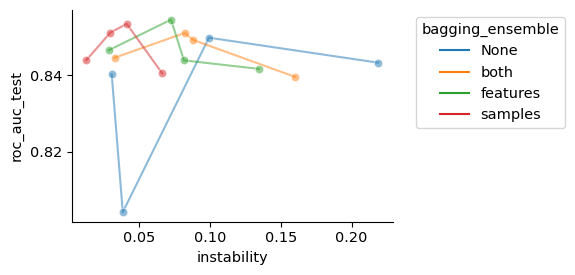

In [70]:
group_keys = [
    k
    for k in imodelsx.process_results.get_main_args_list(
        experiment_filename="01_train_model.py"
    )
    if not k == "seed"
]

df = pd.DataFrame(ravg)
df = (
    df.groupby([k for k in group_keys if not k == "dataset_name"])[
        ["roc_auc_test", "instability"]
    ]
    .mean()
    .reset_index()
)
df = df[df.roc_auc_test >= 0.8]
df = df[df.n_boosting_rounds == 0]
# df = df[df.n_boosting_rounds_marginal == 0]
fig, axes = plt.subplots(1, 1, figsize=(6, 3))
axes = np.array(axes).reshape(1, 1)

kwargs = dict(
    data=df,
    x="instability",
    y="roc_auc_test",
    palette="tab10",
    alpha=0.5,
)
ks = ["bagging_ensemble"]
for i, k in enumerate(ks):
    ax = axes.flatten()[i]
    sns.lineplot(**kwargs, hue=k, ax=ax, marker="o")
    # put legend outside of plot
    ax.legend(
        fontsize="x-small",
        title=k,
        title_fontsize="x-small",
        loc="upper left",
        bbox_to_anchor=(1.05, 1),
    )
    # make all fontsizes small
    for item in (
        [ax.title, ax.xaxis.label, ax.yaxis.label]
        + ax.get_xticklabels()
        + ax.get_yticklabels()
    ):
        item.set_fontsize("x-small")
plt.tight_layout()
plt.show()